# Lecture 8 - Parallelism in Julia

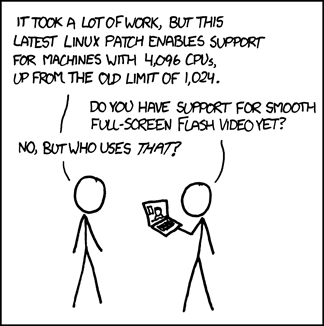
[xkcd/619](https://xkcd.com/619/)

## Contents

1. [CPUs, Cores, and Threads](#cpus)
2. [Parallelism in Julia](#parallelism)
3. [Further Reading](#further-reading)

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.add(["StatsBase","BenchmarkTools"])


## 1. CPUs, Cores, and Threads <a class="anchor" id="cpus"></a>


- From the Wikipedia article on [CPUs](https://en.wikipedia.org/wiki/Central_processing_unit): 

> A central processing unit (CPU)...is the electronic circuitry that executes instructions comprising a computer program.


- Early computer [processors](https://en.wikipedia.org/wiki/Processor_(computing)) consisted of a single CPU (**single-core**), which can execute one set of instructions (or one process) at a time.


- In practice, this means that a single-core processor will constantly switch between individual processes, or threads of execution (this is called **context switching**). This procedure happens so quickly, however, that the user has the illusion that everything is happening simultaneously.

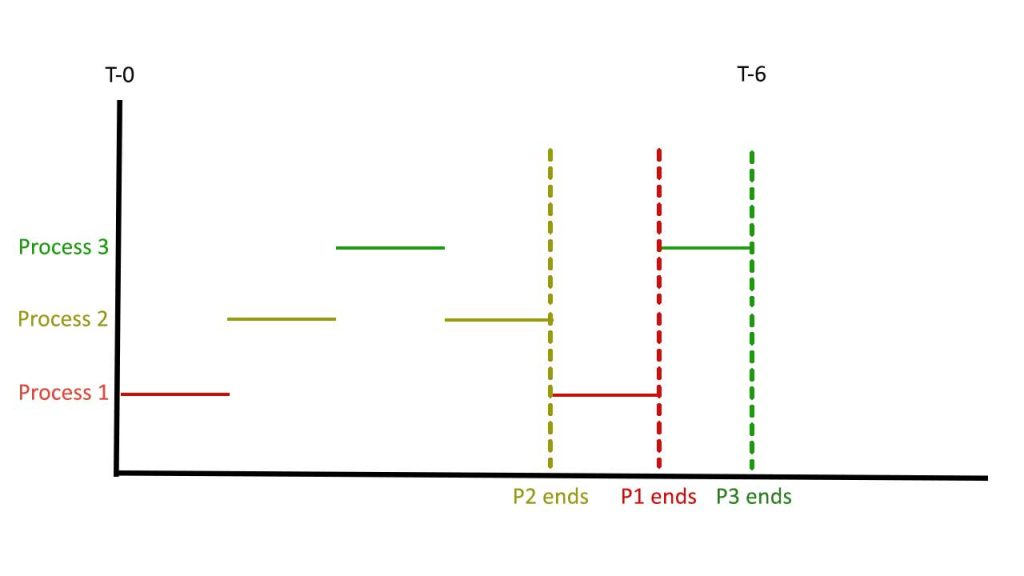
Figure: [temok.com](https://www.temok.com/blog/cores-vs-threads/)

- Modern [microprocessors](https://en.wikipedia.org/wiki/Microprocessor) are almost exclusively **multi-core**, meaning a single processor chip contains multiple physical CPU cores. This means that multiple threads can now genuinely be executed in parallel (it's no longer simply a clever illusion).

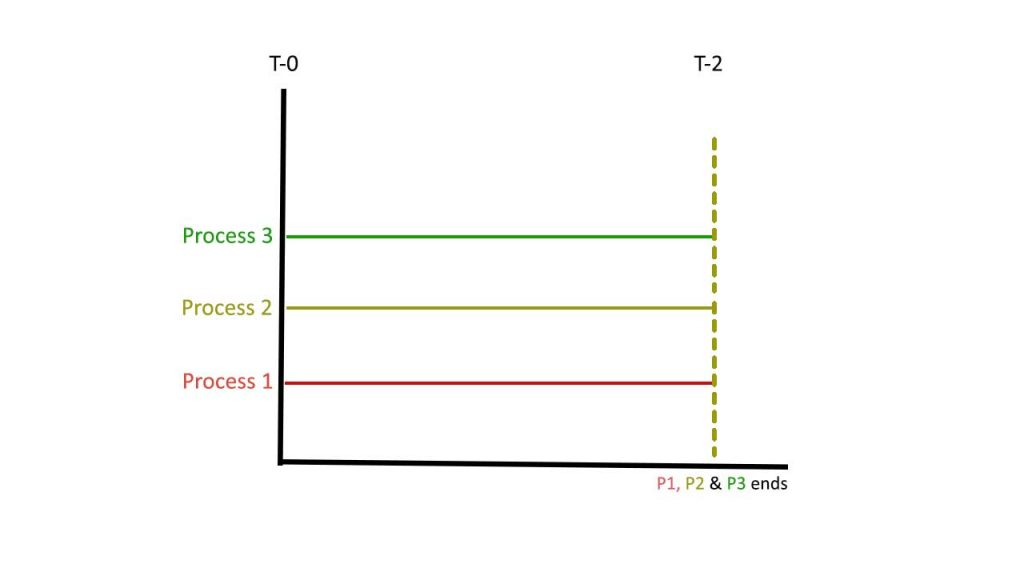
Figure: [temok.com](https://www.temok.com/blog/cores-vs-threads/)

- How many cores does the CPU on your computer have? 

1. On **Linux**, do `lscpu`.
2. On **macOS**, do `sysctl hw.physicalcpu hw.logicalcpu`.
3. On **Windows**, do `WMIC CPU Get NumberOfCores,NumberOfLogicalProcessors` (or go to the Task Manager and select the tab Performance).

In [4]:
; sysctl hw.physicalcpu hw.logicalcpu

hw.physicalcpu: 8
hw.logicalcpu: 8


- According to the output of `lscpu`, I have 8 CPUs on my computer. But that's not quite correct! 


- Let's look at the output more closely:

    - **Socket(s)**: This is the number of microprocessors in my computer. Like most laptops and desktop computers, I have one.
    - **Core(s) per socket**/**Physical CPUs**: This is the number of physical CPU cores my microprocessor has. My processor has 4 (it is a quad-core processor).
    - **Thread(s) per core**: On most x86 CPUs (e.g. Intel or AMD), each core can support two "simultaneous" threads of execution. This is an example of [simultaneous multithreading](https://en.wikipedia.org/wiki/Simultaneous_multithreading) (SMT), also commonly known as [hyper-threading](https://en.wikipedia.org/wiki/Hyper-threading), which allows more than one thread to run simultaneously on a single physical core. Of course, the two processes, running on a single core, are not actually simultaneous. Essentially, the CPU exploits idle time in one thread to execute tasks on the other thread, giving the illusion of genuine parallel execution (along with some, but not all, of the benefit). Hence each *physical core* on these computer appears to the operating system as two *logical cores* on which tasks can be completed. On ARM CPUs (e.g. Apple, Qualcomm, etc) there's no hyper-threading.


- Therefore the total number of threads (logical cores) available for execution on my computer is given by,

$$\mathrm{Sockets} \times \mathrm{Cores\,per\,socket} \times \mathrm{Threads\,per\,core} = 8 \,\mathrm{Threads\,(logical\,cores)}.$$

## 2. Parallelism in Julia <a class="anchor" id="parallelism"></a>

- Given multiple cores (physical or logical) available for parallel execution, it would be great if we could split our computationally intensive Julia programs up into subtasks that can be efficiently executed in parallel. As you've probably guessed, this is extremely straightforward in Julia.

### 2.1. Types of Parallelism in Julia
- Julia supports various different types of parallel programming:

    1. **Multi-Threading**: individual tasks are distributed to multiple threads for parallel execution. This is the easiest to implement on a typical computer or laptop, and will be the focus of today's lecture.
    2. **Distributed Computing**: tasks are distributed to multiple CPUs (or multiple computers), each with its own instance of Julia running, for parallel execution. The supercomputing clusters on which climate models are run are an example of massive distributed computing. The fastest supercomputer in the world, the [Frontier supercomputer]((https://top500.org/news/ornls-frontier-first-to-break-the-exaflop-ceiling/)) at Oak Ridge National Laboratory in the US, has 8,730,112 total cores. It was the first system to break the Exaflop barrier - $10^{18}$ floating-point operations per second - and cost US$600 million to build.
    3. **GPU Programming**: originally intended for computer graphics, GPUs are designed for massively parallel execution, with thousands of small, individual cores. GPUs are particularly well-suited to operations like matrix multiplication, hence their widespread adoption in deep learning applications.

### 2.2. Multi-Threading in Julia
- Multi-threading is parallelism you can do on a single (multi-core) CPU. By default, Julia starts up with a single thread of execution.

In [5]:
Threads.nthreads()

1

In [6]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd48430 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M3
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
Threads: 1 default, 0 interactive, 1 GC (on 4 virtual cores)


- To specify the number of threads when starting Julia from the command line, either use the `--threads` command line argument,

`julia --threads 8`,

or set the environment variable `JULIA_NUM_THREADS`,

`export JULIA_NUM_THREADS=8`.

- To use multiple threads in a Jupyter notebook, you can install a custom kernel spec:

```julia
using IJulia
IJulia.installkernel("Julia (8 Threads)", env=Dict("JULIA_NUM_THREADS" => "8"))
```

- Let's switch the kernel and see how many threads we've got now.

In [1]:
Threads.nthreads()

8

In [2]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd48430 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M3
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
Threads: 8 default, 0 interactive, 4 GC (on 4 virtual cores)
Environment:
  JULIA_NUM_THREADS = 8


- Excellent, now we can write Julia code which will run in parallel across 8 threads.


- The most common and straightforward way of writing multi-threaded code in Julia is to affix the `Threads.@threads` macro in front of a `for` loop.

In [3]:
for i = 1:10
    println("Hello from thread ", Threads.threadid())
end

Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1
Hello from thread 1


In [4]:
Threads.@threads for i = 1:10
    println("Hello from thread ", Threads.threadid())
end

Hello from thread 1
Hello from thread 6
Hello from thread 3
Hello from thread 5
Hello from thread 6
Hello from thread 8
Hello from thread 2
Hello from thread 7
Hello from thread 3
Hello from thread 4


- That's how easy it is implement multi-threading in your Julia programs!


#### 2.2.1. Example 1: Counting Coin Flips
- As a slightly more interesting example, let's say we want to flip a coin $N$ times and return the proportion of heads.

In [9]:
using BenchmarkTools

In [6]:
function count_heads(N)
    heads = zeros(Bool, N)  # Store the result of each coin toss

    for i in eachindex(heads)
        if rand() > 0.5
            heads[i] = true
        end
    end

    return sum(heads) / N
end

count_heads (generic function with 1 method)

In [7]:
N = 10^5
count_heads(N)

0.4993

In [8]:
@btime count_heads(N);

  977.542 μs (3 allocations: 97.81 KiB)


In [9]:
function count_heads_threaded(N)
    heads = zeros(Bool, N)

    Threads.@threads for i in eachindex(heads)
        if rand() > 0.5
            heads[i] = true
        end
    end

    return sum(heads) / N
end

count_heads_threaded (generic function with 1 method)

In [10]:
count_heads_threaded(N)

0.5003

In [11]:
@btime count_heads_threaded(N);

  123.833 μs (44 allocations: 101.92 KiB)


- First notice that we get a slight increase in memory allocations in the threaded version. This is due to the additional accounting done by the `Threads.@threads` macro to create tasks and allocate them to different threads.


- Despite the (very modest) increase in allocations, we still see a **8x speedup** of the multi-threaded code using the 8 cores of the ARM CPU compared to the single-threaded version! On typical x86 CPUs with 8 virtual and 4 physical cores, we'd see roughly a **4x speedup**. 

In [12]:
function count_heads_threaded_fast(flips_per_thread, nthreads)
    heads_master = zeros(nthreads)
    
    Threads.@threads for i in 1:nthreads
        heads = 0
        for j in 1:flips_per_thread
            if rand() > 0.5
                heads += 1
            end
        end
        heads_master[i] = heads
    end

    return sum(heads_master) / (nthreads * flips_per_thread)
end

count_heads_threaded_fast (generic function with 1 method)

In [13]:
@btime count_heads_threaded_fast(10^4, Threads.nthreads())

  24.167 μs (42 allocations: 4.36 KiB)


0.4976625

In [18]:
@btime count_heads_threaded(10^4 * Threads.nthreads())

  106.615 μs (45 allocations: 81.98 KiB)


0.5016375

- So by minimising the overhead of multi-threading, we've reduced the runtime by another 3x.

### 2.3. Race Conditions

- The examples in the previous section are examples of [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) problems, where there is essentially zero dependency or need for communication between the parallel tasks.

- Not all code can be so easily and productively parallelised. In particular, you often need to be careful of [race conditions](https://en.wikipedia.org/wiki/Race_condition#In_software) when writing multi-threaded code:

>A race condition arises in software when a computer program, to operate properly, depends on the sequence or timing of the program's processes or threads.


- To illustrate race conditions, consider an alternative formulation of our coin-tossing procedure in which we simply increment a counter.

In [14]:
function count_heads_counter(N)
    heads = 0  # counter

    for i in 1:N
        if rand() > 0.5
            heads += 1
        end
    end

    return heads / N
end

count_heads_counter (generic function with 1 method)

In [15]:
count_heads_counter(N)

0.50066

In [16]:
function count_heads_counter_threaded(N)
    heads = 0  # counter

    Threads.@threads for i in 1:N
        if rand() > 0.5
            heads += 1
        end
    end

    return heads / N
end

count_heads_counter_threaded (generic function with 1 method)

In [17]:
count_heads_counter_threaded(N)

0.08988

- The function returned without any errors, but the answer is definitely wrong! What's going on here?


- To understand, consider the sequence of events in the case where there are two threads and everything works properly.

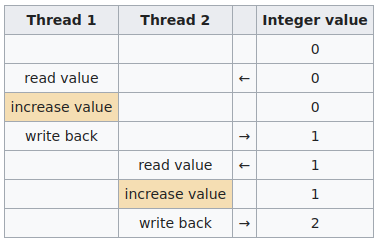
Figure: [Wikipedia](https://en.wikipedia.org/wiki/Race_condition#In_software)
- After incrementing the counter twice, its value is 2, as expected.

- Now consider what happens if the threads overlap, and the precise sequence of events changes.

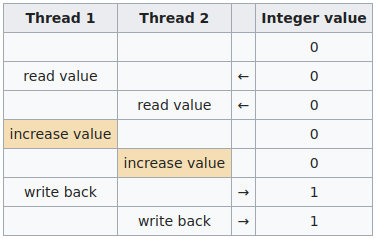
Figure: [Wikipedia](https://en.wikipedia.org/wiki/Race_condition#In_software)

- Now we've incremented the counter twice but its value remains at 1, which is obviously wrong.


- Therefore the program completes without any errors but the result of the calculation is wrong due to the race condition.


- A famous example of a bug due to race conditions is the [Therac-25](https://en.wikipedia.org/wiki/Therac-25) machine for radiation therapy.

### 2.4. Avoiding Race Conditions

- A number of strategies are possible to avoid race conditions in multi-threaded code. 


- The best strategy of all is to **design your code to avoid race conditions in the first place.** This is what we did when we designed our coin-tossing algorithm to store the results in an array rather than incrementing a counter.


- If this simply isn't possible, Julia supports accessing and modifying values **atomically**, that is, in a thread-safe way.


- There are a number of ways to make your code atomic in Julia. The most common method is to use a **lock**. A lock is essentially an object which can only be in the possession of one thread at a time.


- Given a lock `lk`, such as `ReeantrantLock` or `Threads.SpinLock`, atomic operations may be performed with the syntax,

```julia
lock(lk) do
    <atomic work>
end
```

where the lock is automatically released again at the end of the do block.

In [18]:
function count_heads_lock(N)
    heads = 0
    lk = Threads.SpinLock()

    Threads.@threads for i in 1:N
        if rand() > 0.5
            lock(lk) do     # Wait for the lock if it is not available
                heads += 1  # Do atomic work inside the do block, while in possession of the lock
            end
        end
    end

    return heads / N
end

count_heads_lock (generic function with 1 method)

In [19]:
@btime count_heads_lock(N)

  7.773 ms (49036 allocations: 769.78 KiB)


0.50274

- In this (trivial) example, the lock seriously degrades the performance of our routine, emphasising our preference for designing our code to be thread-safe without resorting to atomic operations.   


- However, in normal programs, where the atomic operation makes up a relatively small proportion of the total computation in each iteration, the impact on performance may not be so drastic.

## 3. Further Reading <a class="anchor" id="further-reading"></a>
1. [Julia Parallel Computing](https://docs.julialang.org/en/v1/manual/parallel-computing/)
2. [Julia Multi-Threading](https://docs.julialang.org/en/v1/manual/multi-threading/)